In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, precision_recall_curve, f1_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter


In [19]:

# Load the data
data = pd.read_csv('/kaggle/input/british-airways-customer-bookings/customer_booking.csv', encoding='latin1')

# Create new features
data['is_weekend'] = data['flight_day'].isin(['Sat', 'Sun']).astype(int)
data['total_addons'] = data['wants_extra_baggage'] + data['wants_preferred_seat'] + data['wants_in_flight_meals']

# Prepare features and target
X = data.drop('booking_complete', axis=1)
y = data['booking_complete']

# Separate numerical and categorical columns
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns
categorical_cols = X.select_dtypes(include=["object"]).columns


In [20]:


print("Encode")
# Encode categorical features
X_categorical = X[categorical_cols]
label_encoders = {}
X_encoded = X_categorical.copy()
for col in categorical_cols:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_categorical[col])
    label_encoders[col] = le

print("Combine")
# Combine numeric and encoded categorical features
X_processed = pd.concat([X[numeric_cols], X_encoded.reset_index(drop=True)], axis=1)

print("Scale")
# Scale all features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_processed)
# Convert back to DataFrame for easier handling
X_scaled_df = pd.DataFrame(X_scaled, columns=X_processed.columns)

print("Split")
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.25, random_state=42)

print("SMOTE")
# Apply SMOTE for balancing
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print("Before balancing:", Counter(y_train))
print("After balancing:", Counter(y_train_resampled))


Encode
Combine
Scale
Split
SMOTE
Before balancing: Counter({0: 31874, 1: 5626})
After balancing: Counter({0: 31874, 1: 31874})


In [21]:
# Calculate class weights
class_weights = dict(zip(np.unique(y_train), 
                         len(y_train) / (len(np.unique(y_train)) * np.bincount(y_train))))
print("Calculated class weights:", class_weights)

# Train Random Forest model with adjusted parameters
rf_model = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=4,
    max_features='sqrt',
    bootstrap=True,
    class_weight=class_weights,
    random_state=42,
    oob_score=True
)
rf_model.fit(X_train_resampled, y_train_resampled)

# Train Logistic Regression model with adjusted parameters
lr_model = LogisticRegression(
    C=0.1,
    penalty='l2',
    solver='saga',
    class_weight=class_weights,
    random_state=42,
    max_iter=5000,
    tol=1e-4
)
lr_model.fit(X_train_resampled, y_train_resampled)

Calculated class weights: {0: 0.5882537491372278, 1: 3.3327408460718093}


LogisticRegression(C=0.1,
                   class_weight={0: 0.5882537491372278, 1: 3.3327408460718093},
                   max_iter=5000, random_state=42, solver='saga')

In [22]:
# Custom threshold function to achieve desired precision and recall
def find_optimal_threshold(model, X, y, target_precision=0.7, target_recall=0.7):
    y_scores = model.predict_proba(X)[:, 1]
    precisions, recalls, thresholds = precision_recall_curve(y, y_scores)
    
    # Find threshold that gives closest to target precision and recall
    optimal_idx = np.argmin(np.abs(precisions - target_precision) + np.abs(recalls - target_recall))
    return thresholds[optimal_idx]



Cross-validation F1 scores for RandomForestClassifier:
[0.83762126 0.82075056]
Mean F1 score: 0.8292
Optimal threshold: 0.4813

Classification Report for RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.93      0.70      0.80     10648
           1       0.29      0.70      0.41      1852

    accuracy                           0.70     12500
   macro avg       0.61      0.70      0.60     12500
weighted avg       0.83      0.70      0.74     12500



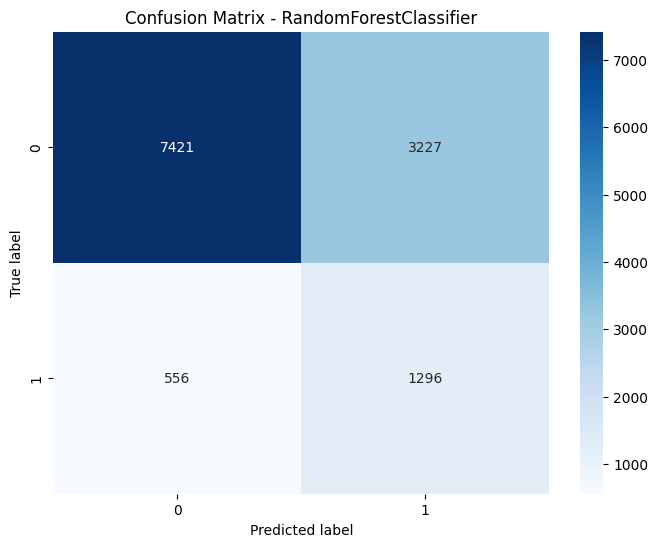


Cross-validation F1 scores for LogisticRegression:
[0.66858572 0.66809341]
Mean F1 score: 0.6683
Optimal threshold: 0.8358

Classification Report for LogisticRegression:
              precision    recall  f1-score   support

           0       0.91      0.56      0.70     10648
           1       0.22      0.70      0.33      1852

    accuracy                           0.58     12500
   macro avg       0.57      0.63      0.51     12500
weighted avg       0.81      0.58      0.64     12500



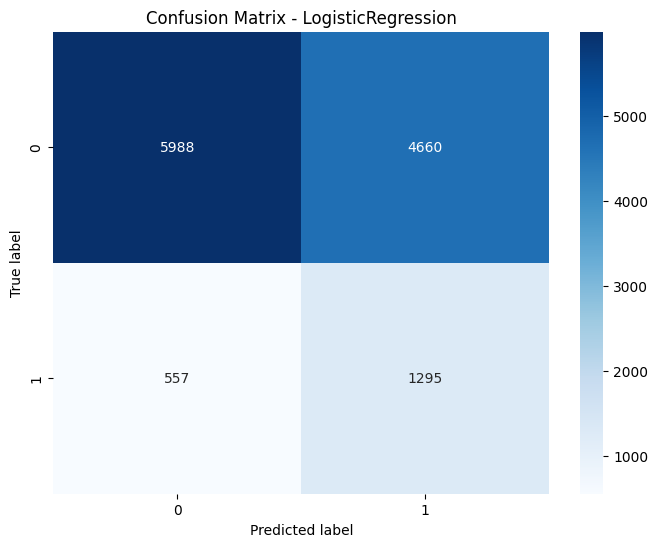


Best model based on mean F1 score: RandomForestClassifier


In [23]:
# Evaluation function with custom threshold
def evaluate_model(model, X_train, y_train, X_test, y_test, cv=2):
    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')
    print(f"\nCross-validation F1 scores for {model.__class__.__name__}:")
    print(cv_scores)
    print(f"Mean F1 score: {cv_scores.mean():.4f}")
    
    # Find optimal threshold
    threshold = find_optimal_threshold(model, X_test, y_test)
    print(f"Optimal threshold: {threshold:.4f}")
    
    # Predictions on test set using optimal threshold
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    print(f"\nClassification Report for {model.__class__.__name__}:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model.__class__.__name__}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(f'Confusion Matrix - {model.__class__.__name__}')
    plt.show()
    
    # Calculate AUC
    auc = roc_auc_score(y_test, y_pred_proba)
    
    return cv_scores.mean(), auc

# Evaluate models
rf_f1, rf_auc = evaluate_model(rf_model, X_train_resampled, y_train_resampled, X_test, y_test)
lr_f1, lr_auc = evaluate_model(lr_model, X_train_resampled, y_train_resampled, X_test, y_test)

# Compare models
best_model = rf_model if rf_f1 > lr_f1 else lr_model
print(f"\nBest model based on mean F1 score: {best_model.__class__.__name__}")

<Figure size 1000x600 with 0 Axes>

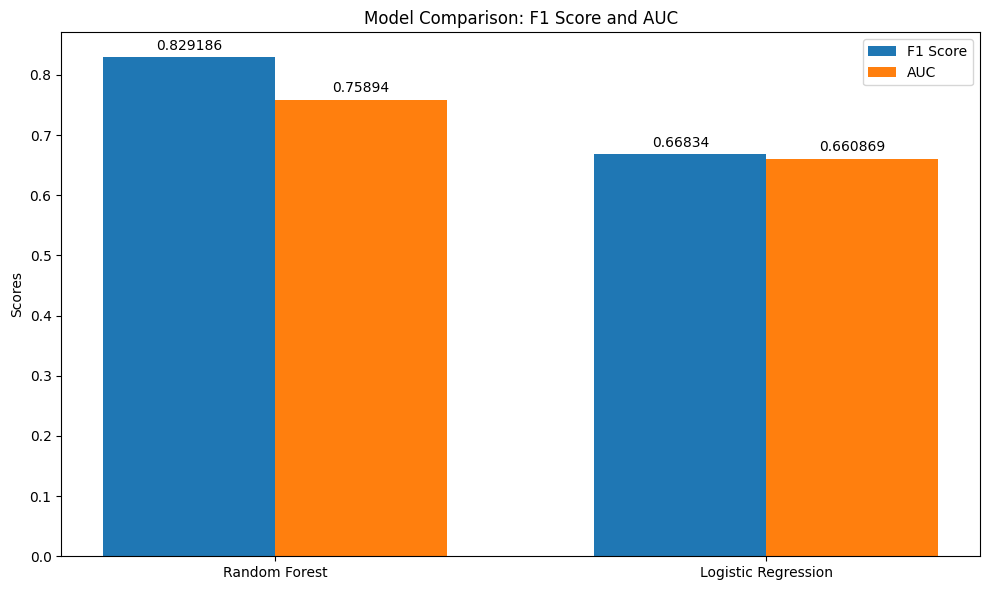

In [24]:
# Comparative figure of both models based on F1 score and AUC
plt.figure(figsize=(10, 6))
models = ['Random Forest', 'Logistic Regression']
f1_scores = [rf_f1, lr_f1]
auc_scores = [rf_auc, lr_auc]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, f1_scores, width, label='F1 Score')
rects2 = ax.bar(x + width/2, auc_scores, width, label='AUC')

ax.set_ylabel('Scores')
ax.set_title('Model Comparison: F1 Score and AUC')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()
plt.savefig("model_comparison.png")
plt.show()


Feature Importance (Top 10):
            feature  importance
14   booking_origin    0.222529
2    length_of_stay    0.123991
13            route    0.120169
1     purchase_lead    0.113141
7   flight_duration    0.111255
3       flight_hour    0.098194
12       flight_day    0.074388
0    num_passengers    0.046408
9      total_addons    0.023843
10    sales_channel    0.016919


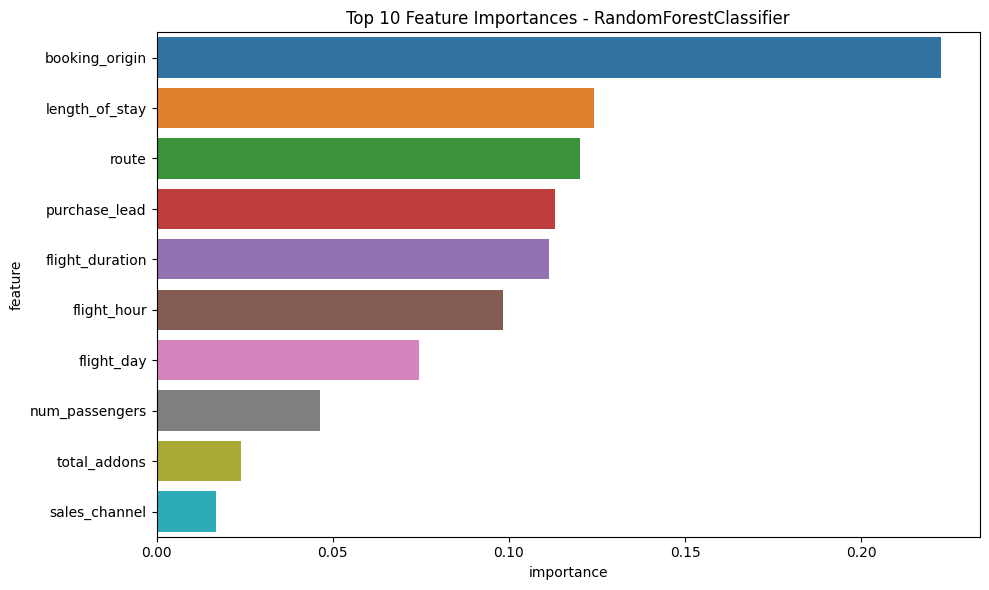

In [25]:
# Feature importance for the best model
feature_names = X_processed.columns
if isinstance(best_model, RandomForestClassifier):
    feature_importance = pd.DataFrame({'feature': feature_names, 'importance': best_model.feature_importances_})
else:
    feature_importance = pd.DataFrame({'feature': feature_names, 'importance': np.abs(best_model.coef_[0])})
feature_importance = feature_importance.sort_values('importance', ascending=False)

print("\nFeature Importance (Top 10):")
print(feature_importance.head(10))

# Visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title(f'Top 10 Feature Importances - {best_model.__class__.__name__}')
plt.tight_layout()
plt.savefig("feature_importance.png")
plt.show()

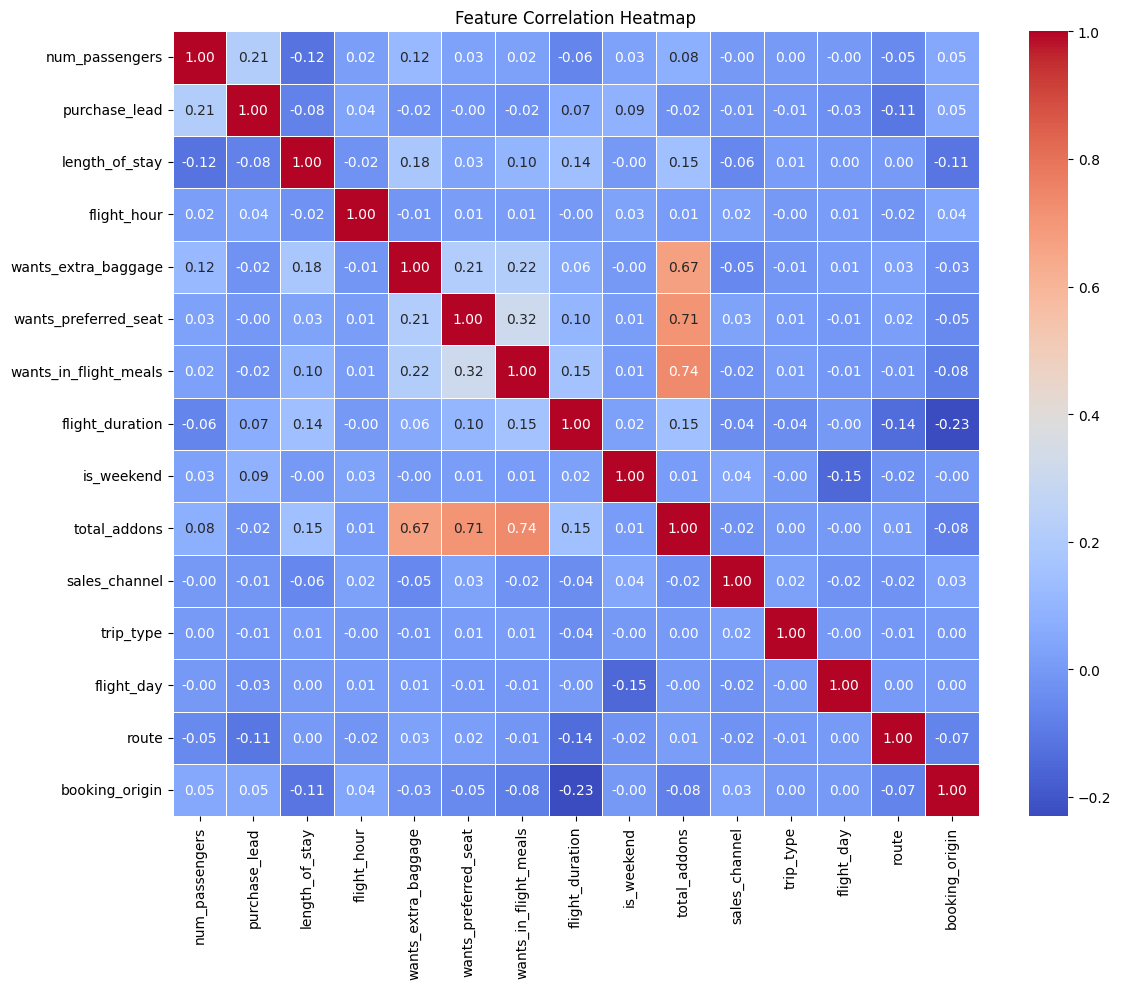


Feature Correlation (Top 10 pairs):
total_addons - wants_in_flight_meals: 0.7377
total_addons - wants_preferred_seat: 0.7079
total_addons - wants_extra_baggage: 0.6701
wants_in_flight_meals - wants_preferred_seat: 0.3151
booking_origin - flight_duration: -0.2304
wants_in_flight_meals - wants_extra_baggage: 0.2165
purchase_lead - num_passengers: 0.2126
wants_preferred_seat - wants_extra_baggage: 0.2077
wants_extra_baggage - length_of_stay: 0.1768
flight_duration - wants_in_flight_meals: 0.1543


In [26]:
# Feature correlation
correlation_matrix = X_processed.corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.savefig("correlation_heatmap.png")
plt.show()

print("\nFeature Correlation (Top 10 pairs):")
correlation_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if i != j:
            correlation_pairs.append((correlation_matrix.index[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]))

correlation_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
for pair in correlation_pairs[:10]:
    print(f"{pair[0]} - {pair[1]}: {pair[2]:.4f}")